In [16]:
import fastf1
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
fastf1.Cache.enable_cache('cache')

In [3]:
session = fastf1.get_session(2024, 'Brazil', 'R')
session.load()

core           INFO 	Loading data for São Paulo Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	No lap data for driver 23
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 23)
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '31', '10', '63', '16'

In [4]:
ver = session.laps.pick_drivers('VER')
ham = session.laps.pick_drivers('HAM')

In [5]:
ver_best_lap = ver.pick_fastest()
ham_best_lap = ham.pick_fastest()

In [21]:
ver_telemetry = ver_best_lap.get_telemetry()
ham_telemetry = ham_best_lap.get_telemetry()

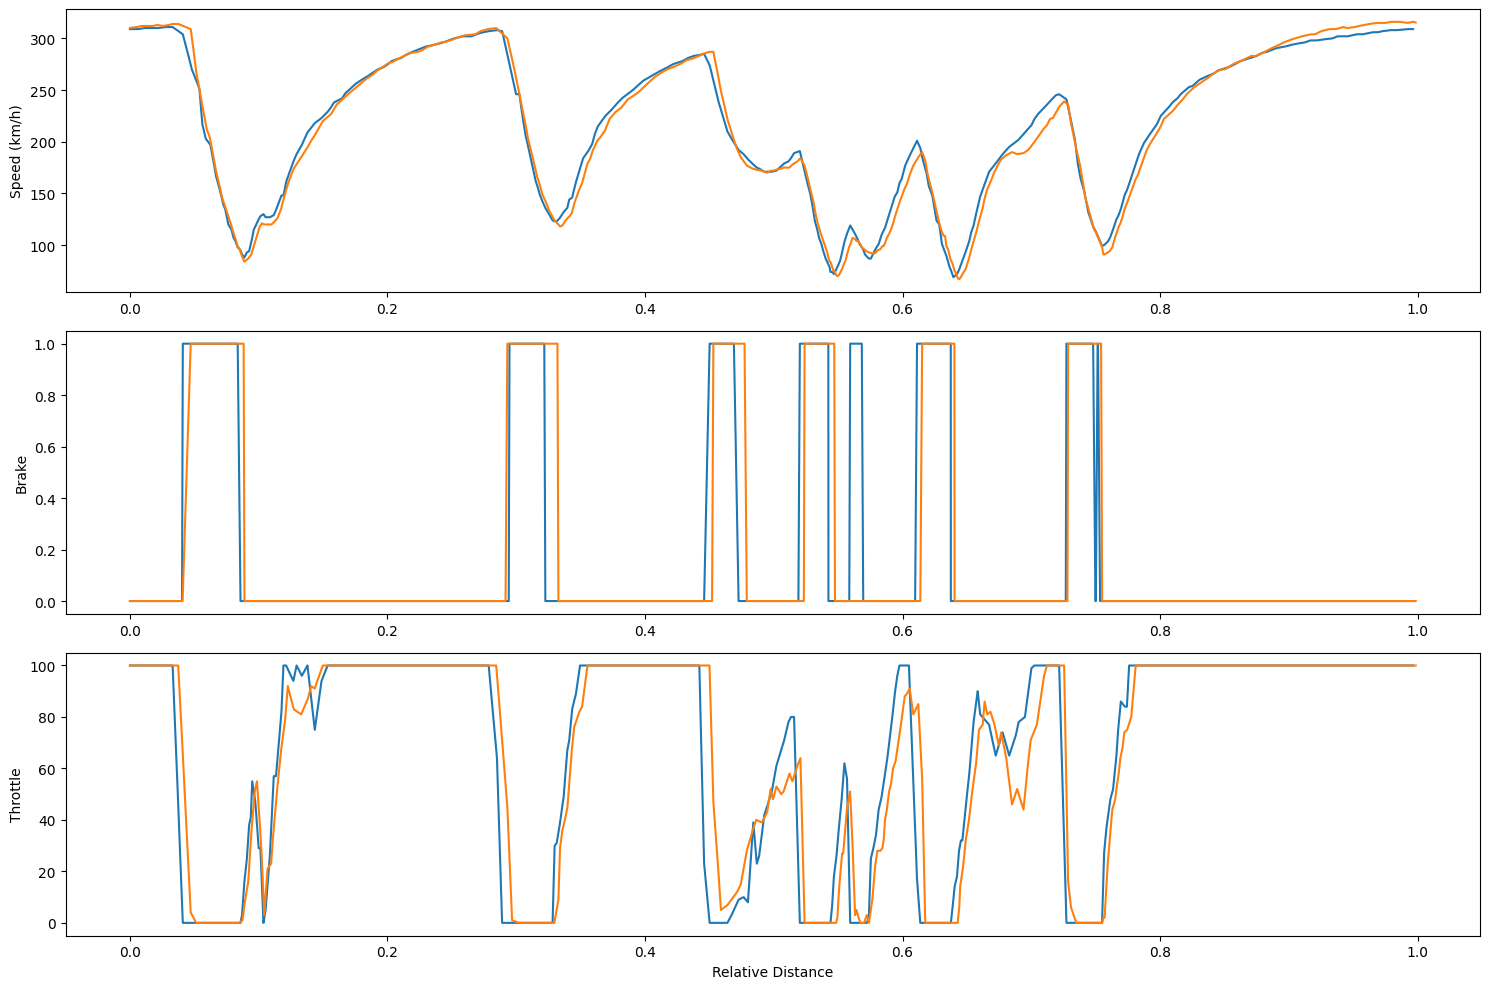

In [22]:
fig, axs = plt.subplots(3, 1, figsize=(15, 10))

axs[0].plot(ver_telemetry.RelativeDistance, ver_telemetry.Speed)
axs[0].plot(ham_telemetry.RelativeDistance, ham_telemetry.Speed)
axs[0].set_ylabel('Speed (km/h)')

axs[1].plot(ver_telemetry.RelativeDistance, ver_telemetry.Brake)
axs[1].plot(ham_telemetry.RelativeDistance, ham_telemetry.Brake)
axs[1].set_ylabel('Brake')

axs[2].plot(ver_telemetry.RelativeDistance, ver_telemetry.Throttle)
axs[2].plot(ham_telemetry.RelativeDistance, ham_telemetry.Throttle)
axs[2].set_ylabel('Throttle')
axs[2].set_xlabel('Relative Distance')

plt.tight_layout()
plt.savefig('telemetry_ver.png', dpi=300)
plt.show()

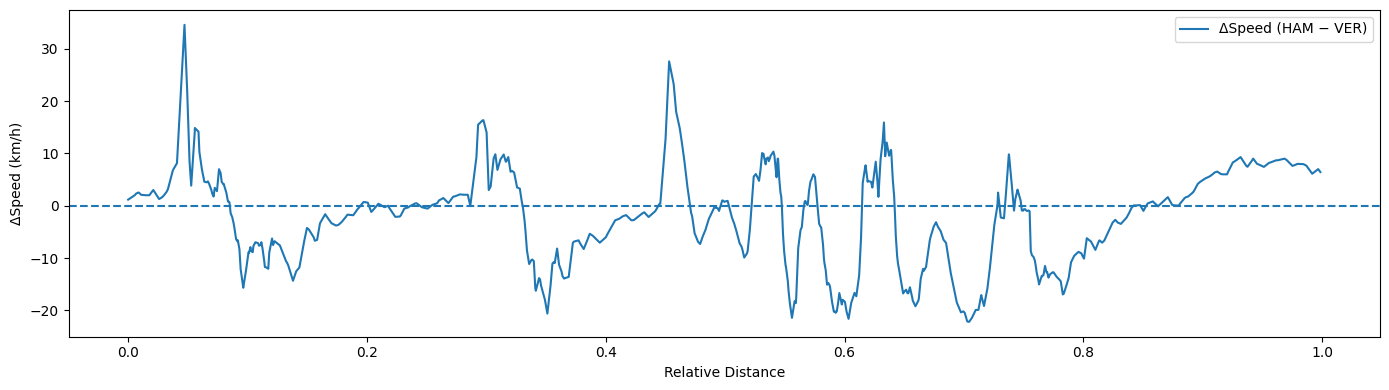

59,87% VER
40,13% HAM


In [39]:
from scipy.interpolate import interp1d

d_speed_df = pd.DataFrame()
d_speed_df['RelDist'] = ham_telemetry.RelativeDistance
d_speed_df['Speed_HAM'] = ham_telemetry.Speed

ver_interp = interp1d(
    ver_telemetry.RelativeDistance,
    ver_telemetry.Speed,
    bounds_error=False,
    fill_value="extrapolate"
)

d_speed_df['Speed_VER_interp'] = ver_interp(d_speed_df['RelDist'])

d_speed_df['DeltaSpeed'] = (
    d_speed_df['Speed_HAM'] - d_speed_df['Speed_VER_interp']
)

plt.figure(figsize=(14, 4))
plt.plot(d_speed_df['RelDist'], d_speed_df['DeltaSpeed'], label='ΔSpeed (HAM − VER)')
plt.axhline(0, linestyle='--')
plt.xlabel('Relative Distance')
plt.ylabel('ΔSpeed (km/h)')
plt.legend()
plt.tight_layout()
plt.show()

v_pct = (d_speed_df.DeltaSpeed < 0).mean()
h_pct = (d_speed_df.DeltaSpeed >= 0).mean()

print(f'{v_pct*100:.2f}% VER'.replace('.', ','))
print(f'{h_pct*100:.2f}% HAM'.replace('.', ','))

In [43]:
sector_1 = d_speed_df[d_speed_df['RelDist'] < 0.33]
sector_2 = d_speed_df[(d_speed_df['RelDist'] >= 0.33) & (d_speed_df['RelDist'] < 0.67)]
sector_3 = d_speed_df[d_speed_df['RelDist'] >= 0.67]

print("\n📊 SECTOR ANALYSIS:")
print(f" 1: VER {(sector_1.DeltaSpeed < 0).mean()*100:.1f}% | HAM {(sector_1.DeltaSpeed >= 0).mean()*100:.1f}%")
print(f" 2: VER {(sector_2.DeltaSpeed < 0).mean()*100:.1f}% | HAM {(sector_2.DeltaSpeed >= 0).mean()*100:.1f}%")
print(f" 3: VER {(sector_3.DeltaSpeed < 0).mean()*100:.1f}% | HAM {(sector_3.DeltaSpeed >= 0).mean()*100:.1f}%")


📊 SECTOR ANALYSIS:
 1: VER 47.8% | HAM 52.2%
 2: VER 68.2% | HAM 31.8%
 3: VER 59.8% | HAM 40.2%


In [40]:
ver_telemetry.to_csv('telemetry_VER_brazil_2024.csv', index=False)
ham_telemetry.to_csv('telemetry_HAM_brazil_2024.csv', index=False)